# 04 - SVM RBF Parameters Tuning

## Prerequisites



In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


# Experiment name will be used to prefix potential outputs
EXP_NAME = "04 - SVM RBF"

# Dataset name is the master key for dataset adressing
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))


[2020-08-22/15:32:06.432|13.4%|64.8%|0.26GB] ------------------------------------------------------
[2020-08-22/15:32:06.432|00.0%|64.8%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] SAMPLE RATE           : 22050
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] DURATION              : 1.0
[2020-08-22/15:32:06.433|00.0%|64.8%|0.26GB] OVERLAP               : 0.0
[2020-08-22/15:32:06.434|00.0%|64.8%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-22/15:32:06.434|00.0%|64.8%|0.26GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from audace.audidataset import feature_serie_to_np
from audace.plotters import save_fig
from audace.jupytools import predestination, iprint

# Experiment parameters
FEATURE_NAME='mfcc20'
SET_FRAC = 0.5
TEST_FRAC = 0.3


# Seed the various PRNGs, for reproducibility
predestination()

# #############################################################################
# Prepare data set for grid search

# Get pandas dataframe containing the columns we will need for this experiments
# we take a random smaller portion, to reduce computation time
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

X = feature_serie_to_np(df[FEATURE_NAME])
y = df['queen']

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit here as we are scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set, but this should not significantly
# bias the hyper-parameters tuning

scaler = StandardScaler()
X = scaler.fit_transform(X)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis# 10 is often enough.
# Using a basis of 2, a finer tuning can be achieved but at a much higher cost.

#C_range = np.logspace(-5, 5, 11)
#gamma_range = np.logspace(-5, 5, 11)
C_range = np.linspace(8, 12, 10)
gamma_range = np.linspace(.0005, 0.0015, 11)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=TEST_FRAC)
iprint("Starting GridSearch")
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

iprint("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

[2020-08-22/18:21:42.776|02.7%|67.7%|0.22GB] Starting GridSearch


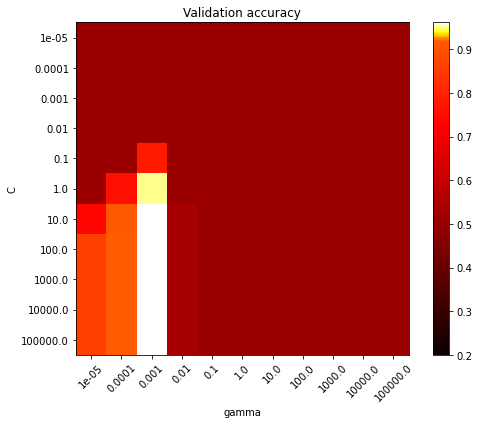

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
save_fig('SVM hyper-parameters grid search heatmap')
plt.show()

In [8]:
display(scores)

array([[0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.50581395, 0.50581395, 0.71104651, 0.50581395, 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.50581395, 0.7255814 , 0.95232558, 0.50581395, 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.69069767, 0.88604651, 0.99011628, 0.95      , 0.50581395,
        0.50581395, 0.50581395, 0.50581395, 0.50581395, 0.50581395,
        0.50581395],
       [0.86627907, 0.96918605, 0.98895349, 0.94767442, 0.